In [ ]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.layers import Reshape, Permute
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

In [2]:
def build_rand_feat():
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        if wav.shape[0] < config.step:
            pad_width = config.step - wav.shape[0]
            wav = np.pad(wav, (0, pad_width), mode='constant')
        if wav.shape[0] == config.step:
            sample = wav
        else:
            rand_index = np.random.randint(0, wav.shape[0] - config.step)
            sample = wav[rand_index:rand_index + config.step]
        X_sample = mfcc(sample, rate,
                        numcep=config.nfeat, nfilt=config.nfilt, nfft = config.nfft).T
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=36)
    return X, y
        

In [3]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1,1),
                     padding = 'same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1),
                     padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),
                     padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1),
                     padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(36, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [4]:
def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(36, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [5]:
def get_cnn_lstm_model(input_shape, num_classes=36):
    model = Sequential()

    # --- Feature extractor CNN ---
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.3))

    # Ahora transformamos el mapa de características en secuencia temporal
    # reshape: (batch, time_steps, features)
    model.add(Permute((2,1,3)))   # intercambiar ejes (para que el "tiempo" quede bien)
    model.add(Reshape((-1, 64)))  # -1 => número de frames, 64 => features por frame

    # --- Secuencia temporal con LSTM ---
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))

    # --- Fully connected classifier ---
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [6]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

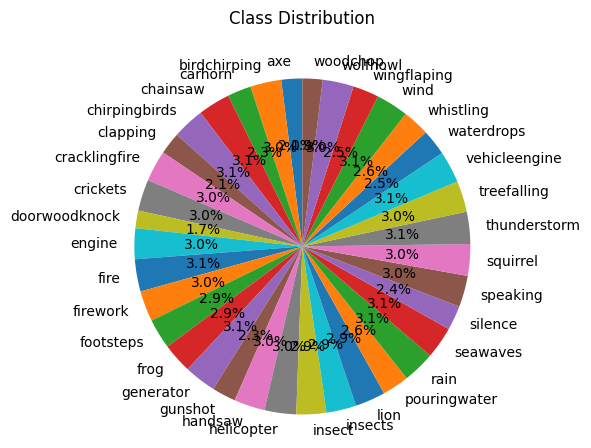

In [7]:
df = pd.read_csv('FSC22andESC50.csv')
df.set_index('filename', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [ ]:
config = Config(mode='conv')

if config.mode == 'conv':
    X, y = build_rand_feat()   # <- aquí y puede ser one-hot o entero
    y_flat = np.argmax(y, axis=1)   # <- convertir a enteros solo para class_weight
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()

elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

elif config.mode == 'hybrid':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_cnn_lstm_model(input_shape, num_classes=36)


# class weights SOLO con y en enteros
class_weight_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_flat),
    y=y_flat
)
class_weight = dict(zip(np.unique(y_flat), class_weight_vals))

# entrenar con y one-hot
model.fit(X, y, epochs=100, batch_size=32,
          shuffle=True, class_weight=class_weight)




100%|██████████| 240906/240906 [04:39<00:00, 860.43it/s]
c:\Users\W11\OneDrive - UNIVERSIDAD DE INGENIERIA Y TECNOLOGIA\Escritorio\Datasets ESC\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 9, 16)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 9, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 9, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,092 (1.91 MB)

 Trainable params: 501,092 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 77s 10ms/step - acc: 0.4203 - loss: 2.0450
Epoch 2/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 77s 10ms/step - acc: 0.5702 - loss: 1.4846
Epoch 3/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - acc: 0.6187 - loss: 1.3127
Epoch 4/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - acc: 0.6458 - loss: 1.2135
Epoch 5/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - acc: 0.6657 - loss: 1.1415
Epoch 6/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - acc: 0.6815 - loss: 1.0825
Epoch 7/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 77s 10ms/step - acc: 0.6924 - loss: 1.0429
Epoch 8/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - acc: 0.7023 - loss: 1.0088
Epoch 9/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 77s 10ms/step - acc: 0.7109 - loss: 0.9744
Epoch 10/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - acc: 0.7173 - loss: 0.9519
Epoch 11/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - acc: 0.7232 - loss: 0.9293
Epoch 12/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms

7529/7529 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


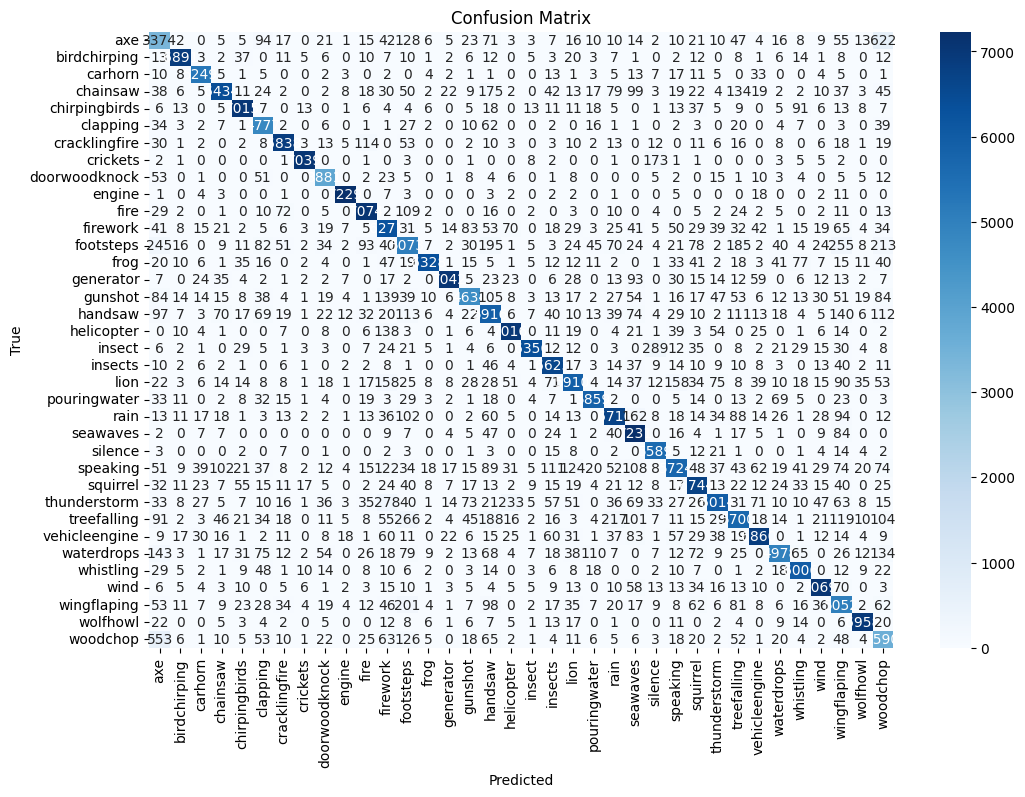

Classification Report:
               precision    recall  f1-score   support

          axe       0.65      0.72      0.68      4689
 birdchirping       0.97      0.97      0.97      7119
      carhorn       0.95      0.97      0.96      5411
     chainsaw       0.94      0.87      0.90      7388
chirpingbirds       0.95      0.95      0.95      7356
     clapping       0.86      0.95      0.90      5033
cracklingfire       0.95      0.95      0.95      7209
     crickets       0.99      0.97      0.98      7249
doorwoodknock       0.91      0.95      0.93      4106
       engine       0.99      0.99      0.99      7294
         fire       0.93      0.96      0.94      7405
     firework       0.81      0.88      0.84      7110
    footsteps       0.76      0.74      0.75      6900
         frog       0.98      0.92      0.95      6842
    generator       0.98      0.94      0.96      7506
      gunshot       0.91      0.83      0.86      5608
      handsaw       0.79      0.84      0

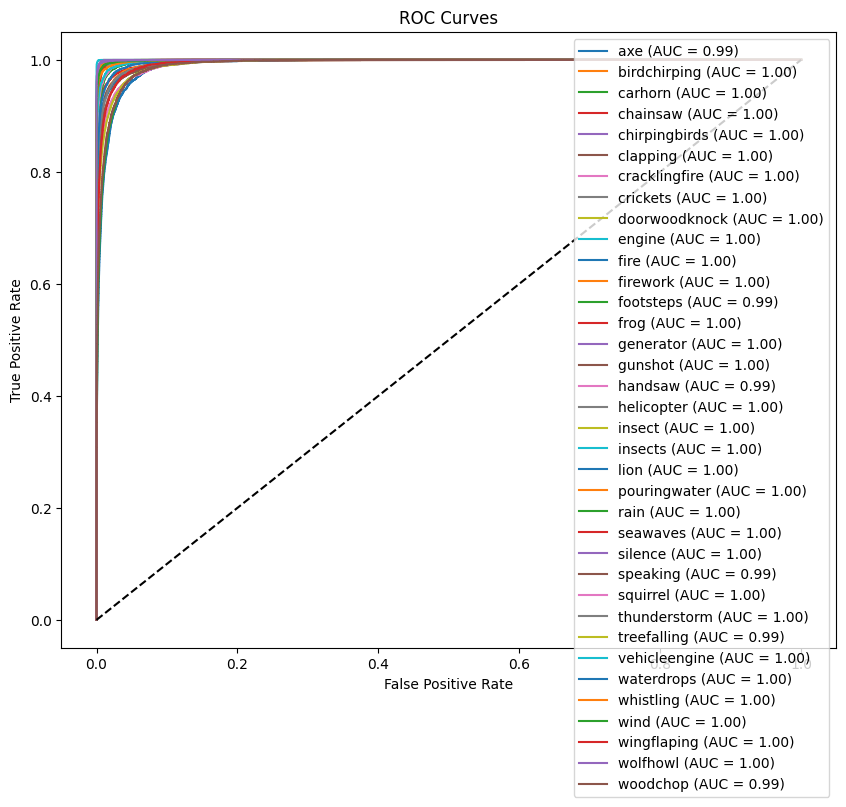

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ========= 1. Matriz de confusión =========
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ========= 2. Reporte de clasificación =========
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# ========= 3. ROC Curves =========
# Binarizamos etiquetas para One-vs-Rest ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [9]:
config = Config(mode='time')

if config.mode == 'conv':
    X, y = build_rand_feat()   # <- aquí y puede ser one-hot o entero
    y_flat = np.argmax(y, axis=1)   # <- convertir a enteros solo para class_weight
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()

elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

# class weights SOLO con y en enteros
class_weight_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_flat),
    y=y_flat
)
class_weight = dict(zip(np.unique(y_flat), class_weight_vals))

# entrenar con y one-hot
model.fit(X, y, epochs=100, batch_size=32,
          shuffle=True, class_weight=class_weight)



100%|██████████| 240906/240906 [04:57<00:00, 809.31it/s]
c:\Users\W11\OneDrive - UNIVERSIDAD DE INGENIERIA Y TECNOLOGIA\Escritorio\Datasets ESC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 9, 128)         │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 9, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 9, 64)          │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 9, 32)          │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 9, 16)          │           528 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 9, 8)           │           136 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 36)             │         2,628 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,916 (851.23 KB)

 Trainable params: 217,916 (851.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - acc: 0.1838 - loss: 2.9256
Epoch 2/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - acc: 0.3080 - loss: 2.4350
Epoch 3/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - acc: 0.3724 - loss: 2.1980
Epoch 4/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - acc: 0.4204 - loss: 2.0368
Epoch 5/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - acc: 0.4564 - loss: 1.9143
Epoch 6/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 74s 10ms/step - acc: 0.4875 - loss: 1.8034
Epoch 7/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - acc: 0.5163 - loss: 1.7114
Epoch 8/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - acc: 0.5399 - loss: 1.6295
Epoch 9/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - acc: 0.5609 - loss: 1.5581
Epoch 10/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - acc: 0.5797 - loss: 1.4924
Epoch 11/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - acc: 0.5980 - loss: 1.4333
Epoch 12/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms

7529/7529 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step


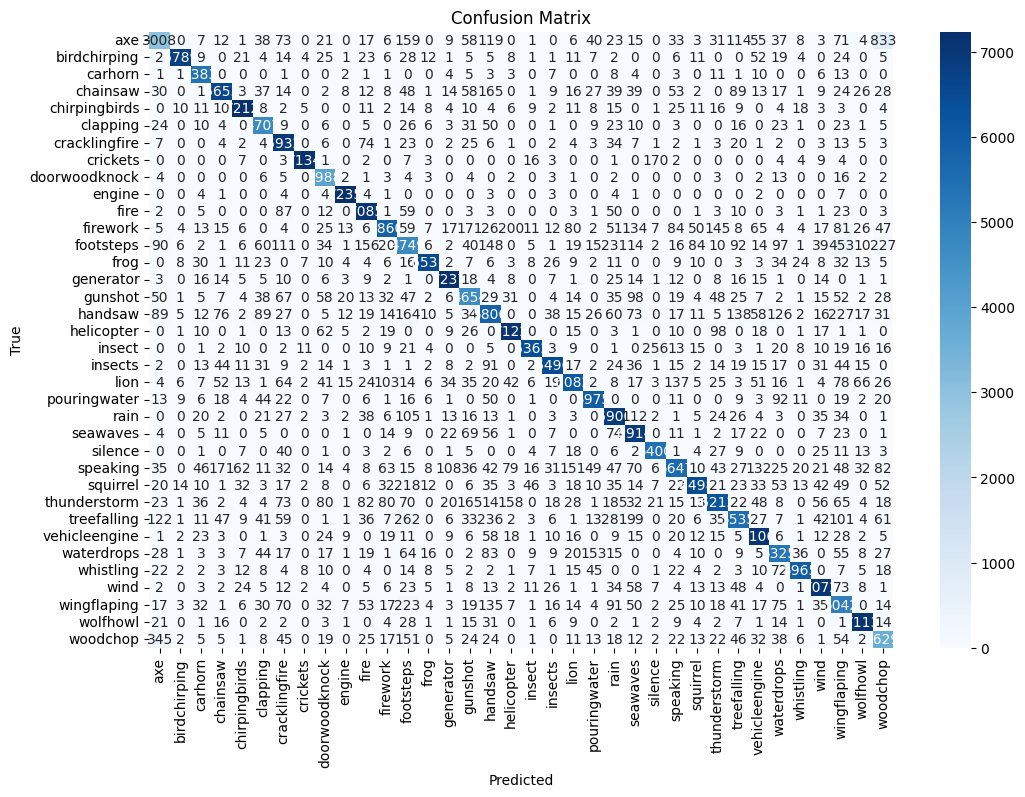

Classification Report:
               precision    recall  f1-score   support

          axe       0.76      0.63      0.69      4805
 birdchirping       0.99      0.96      0.97      7100
      carhorn       0.94      0.98      0.96      5468
     chainsaw       0.93      0.89      0.91      7447
chirpingbirds       0.96      0.97      0.97      7456
     clapping       0.89      0.94      0.92      4996
cracklingfire       0.88      0.96      0.92      7191
     crickets       0.99      0.97      0.98      7370
doorwoodknock       0.88      0.98      0.93      4066
       engine       0.98      0.99      0.99      7273
         fire       0.91      0.96      0.94      7356
     firework       0.92      0.81      0.86      7259
    footsteps       0.71      0.70      0.71      6762
         frog       0.98      0.95      0.97      6866
    generator       0.96      0.97      0.96      7457
      gunshot       0.83      0.86      0.85      5418
      handsaw       0.80      0.80      0

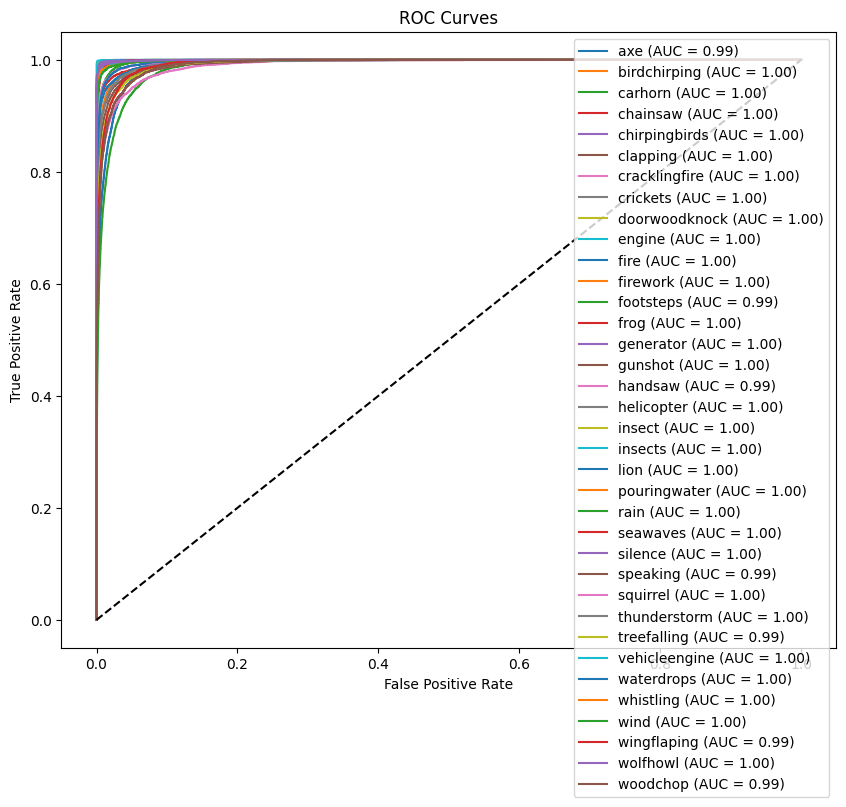

In [10]:
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ========= 2. Reporte de clasificación =========
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# ========= 3. ROC Curves =========
# Binarizamos etiquetas para One-vs-Rest ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [8]:
config = Config(mode='hybrid')

if config.mode == 'conv':
    X, y = build_rand_feat()   # <- aquí y puede ser one-hot o entero
    y_flat = np.argmax(y, axis=1)   # <- convertir a enteros solo para class_weight
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()

elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

elif config.mode == 'hybrid':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_cnn_lstm_model(input_shape, num_classes=36)


# class weights SOLO con y en enteros
class_weight_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_flat),
    y=y_flat
)
class_weight = dict(zip(np.unique(y_flat), class_weight_vals))

# entrenar con y one-hot
model.fit(X, y, epochs=100, batch_size=32,
          shuffle=True, class_weight=class_weight)


100%|██████████| 240906/240906 [05:40<00:00, 706.55it/s]
c:\Users\W11\OneDrive - UNIVERSIDAD DE INGENIERIA Y TECNOLOGIA\Escritorio\Datasets ESC\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 9, 13, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 6, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,372 (1.03 MB)

 Trainable params: 270,372 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 69s 9ms/step - acc: 0.2040 - loss: 2.8203
Epoch 2/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 65s 9ms/step - acc: 0.3133 - loss: 2.3858
Epoch 3/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 68s 9ms/step - acc: 0.3783 - loss: 2.1492
Epoch 4/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - acc: 0.4192 - loss: 2.0065
Epoch 5/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step - acc: 0.4507 - loss: 1.8964
Epoch 6/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 71s 9ms/step - acc: 0.4794 - loss: 1.7988
Epoch 7/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 71s 9ms/step - acc: 0.5012 - loss: 1.7284
Epoch 8/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step - acc: 0.5191 - loss: 1.6632
Epoch 9/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 118s 16ms/step - acc: 0.5324 - loss: 1.6116
Epoch 10/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - acc: 0.5454 - loss: 1.5694
Epoch 11/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - acc: 0.5583 - loss: 1.5309
Epoch 12/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step 